## Importing important libraries

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification, RobertaConfig
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import joblib
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import re
from nltk.tokenize import sent_tokenize
from sklearn.utils.class_weight import compute_class_weight

2024-03-28 09:10:26.359371: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 09:10:26.359430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 09:10:26.360437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 09:10:26.365756: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Hyperparameters 

Easy and straightforward hyperparameter tuning

In [2]:
# Hyperparameters and paths
BATCH_SIZE = 64
LEARNING_RATE = 2e-5
EPOCHS = 30
TEST_SIZE = 0.18
RANDOM_STATE = 42
MAX_LEN = 128  # Maximum sequence length for tokenization
NUM_LABELS = 6  # Update based on your dataset

base_save_path = "Roberta_v3_5f_checkpoints"
checkpoint_path = "Roberta_v3_5f_checkpoints/cp-{epoch:04d}.ckpt"

# Load and preprocess the dataset
file_path = 'emotion_data_merged_4.csv'  # Update this path
data = pd.read_csv(file_path)

## F1 Metric and tokenizer function

In [3]:
def f1_metric(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Setup and Data Preparation

Loading the dataset, preprocessing the text, and preparing the data for the model.

In [4]:
# Function to limit the number of rows per emotion class
def limit_rows(group):
    return group.sample(n=min(len(group), 59285), random_state=42)

In [5]:
data = data.dropna(subset=['emotion']).query("emotion != 'neutral'")
data = data.drop_duplicates()
# Group by 'emotion' and apply the limiting function
data = data.groupby('emotion', group_keys=False).apply(limit_rows)

/tmp/ipykernel_4070350/3510343987.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('emotion', group_keys=False).apply(limit_rows)


In [6]:
# Expanded contraction mapping
contractions_dict = {
    "i'm": "i am", "im": "i am", "i m": "i am",
    "you're": "you are", "youre": "you are",
    "he's": "he is", "hes": "he is",
    "she's": "she is", "shes": "she is",
    "it's": "it is", "its": "it is",
    "we're": "we are", "were": "we are",
    "they're": "they are", "theyre": "they are",
    "that's": "that is", "thats": "that is", "that s": "that is",
    "that'd": "that would", "thatd": "that would",
    "who's": "who is", "whos": "who is",
    "what's": "what is", "whats": "what is",
    "where's": "where is", "wheres": "where is",
    "when's": "when is", "whens": "when is",
    "why's": "why is", "whys": "why is",
    "how's": "how is", "hows": "how is",
    "ain't": "am not", "aint": "am not",
    "aren't": "are not", "arent": "are not",
    "isn't": "is not", "isnt": "is not",
    "wasn't": "was not", "wasnt": "was not",
    "weren't": "were not", "werent": "were not",
    "haven't": "have not", "havent": "have not",
    "hasn't": "has not", "hasnt": "has not",
    "hadn't": "had not", "hadnt": "had not",
    "won't": "will not", "wont": "will not",
    "wouldn't": "would not", "wouldnt": "would not",
    "don't": "do not", "dont": "do not",
    "doesn't": "does not", "doesnt": "does not",
    "didn't": "did not", "didnt": "did not",
    "can't": "cannot", "cant": "cannot",
    "couldn't": "could not", "couldnt": "could not",
    "shouldn't": "should not", "shouldnt": "should not",
    "mightn't": "might not", "mightnt": "might not",
    "mustn't": "must not", "mustnt": "must not",
}

# Create a regex pattern for contractions, enabling case-insensitive matching
contraction_patterns = r'\b(' + '|'.join([re.escape(k) for k in contractions_dict.keys()]) + r')\b'
contractions_re = re.compile(contraction_patterns, re.IGNORECASE)

In [7]:
def expand_contractions(text, contractions_dict=contractions_dict):
    def replace(match):
        # Fetch the correct replacement string from the dictionary using lowercase match
        return contractions_dict[match.group().lower()]
    # Use the sub method to replace all matches
    expanded_text = contractions_re.sub(replace, text)
    return expanded_text

def clean_text(text):
    text = text.strip()  # Strip leading/trailing whitespace
    text = expand_contractions(text)  # Expand contractions
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)  # Remove emoticons and unicode characters
    
    # Split text into sentences, strip each sentence, then join back with a space
    sentences = sent_tokenize(text)
    cleaned_sentences = [sentence.strip() for sentence in sentences]
    text = ' '.join(cleaned_sentences)
    
    return text

In [8]:
data['sentence'] = data['sentence'].apply(clean_text)

# Drop duplicates
data = data.drop_duplicates()

# Overview of the dataset
print("Preview of the dataset:")
print(data.head())

print("\nSummary statistics of the dataset:")
print(data.describe())

print("\nInformation about columns in the dataset:")
print(data.info())

# Feature extraction
data['ends_with_exclamation'] = data['sentence'].str.endswith('!').astype(int)
data['ends_with_question'] = data['sentence'].str.endswith('?').astype(int)
data['ends_with_period'] = data['sentence'].str.endswith('.').astype(int)

Preview of the dataset:
                                                 sentence emotion
64376   Fine, but I’ll have you know that once I taugh...   anger
258476                            i was feeling irritated   anger
155604  i couldn t keep the feelings inside and my fri...   anger
287956  i know he is trying to help but it just makes ...   anger
292299  i am feeling much less rebellious against anti...   anger

Summary statistics of the dataset:
                                           sentence    emotion
count                                        283522     283522
unique                                       283506          6
top     Ahh. Ooh, is this a ah, is this a bad time?  happiness
freq                                              2      59222

Information about columns in the dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 283522 entries, 64376 to 617757
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 

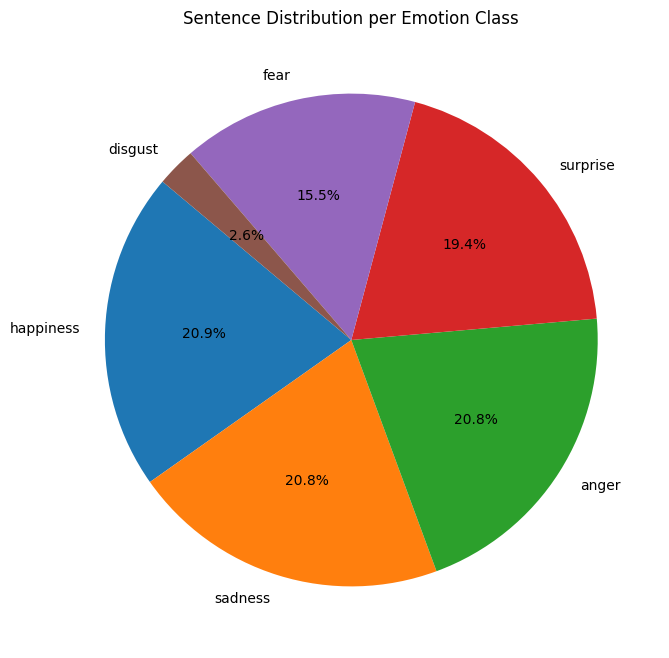

Number of sentences in the 'anger' class: 58874


In [9]:
# Count the number of sentences for each emotion
emotion_counts = data['emotion'].value_counts()

# Plotting the pie chart for sentence distribution per class
plt.figure(figsize=(10, 8))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentence Distribution per Emotion Class')
plt.show()
# Count the number of sentences for the 'anger' emotion
anger_count = data[data['emotion'] == 'anger'].shape[0]

print(f"Number of sentences in the 'anger' class: {anger_count}")

In [10]:
data.head()

,sentence,emotion,ends_with_exclamation,ends_with_question,ends_with_period
64376,"Fine, but I’ll have you know that once I taugh...",anger,0,0,1
258476,i was feeling irritated,anger,0,0,0
155604,i couldn t keep the feelings inside and my fri...,anger,0,0,0
287956,i know he is trying to help but it just makes ...,anger,0,0,0
292299,i am feeling much less rebellious against anti...,anger,0,0,0


In [11]:
# Encode the labels
label_encoder = LabelEncoder()
data['emotion_encoded'] = label_encoder.fit_transform(data['emotion'])

# Initial train-validation split
train_data, initial_val_data = train_test_split(data, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data['emotion_encoded'])

# Generate embeddings for the validation sentences
model = SentenceTransformer('all-MiniLM-L6-v2')
val_embeddings = model.encode(initial_val_data['sentence'].values)

# Clustering
kmeans = MiniBatchKMeans(n_clusters=int(len(initial_val_data) * TEST_SIZE / 10), random_state=RANDOM_STATE)
val_cluster_labels = kmeans.fit_predict(val_embeddings)
initial_val_data['cluster_label'] = val_cluster_labels

# Sample from clusters to form the final validation set
# Instead of sampling a fixed number from each cluster, we aim to maintain the overall desired validation set size
desired_val_size = int(len(data) * TEST_SIZE)  # This is the target size for the validation set

# Calculate the sampling ratio for each cluster to contribute to the final validation set
cluster_counts = initial_val_data['cluster_label'].value_counts()
sampling_ratios = cluster_counts / cluster_counts.sum()

# Calculate the number of samples to take from each cluster
samples_per_cluster = (sampling_ratios * desired_val_size).round().astype(int)

# Sample from each cluster
val_data_list = []
for cluster_label, n_samples in samples_per_cluster.items():
    cluster_data = initial_val_data[initial_val_data['cluster_label'] == cluster_label]
    sampled_data = cluster_data.sample(n=min(n_samples, len(cluster_data)), random_state=RANDOM_STATE)
    val_data_list.append(sampled_data)

# Concatenate all sampled data to form the final validation set
val_data = pd.concat(val_data_list).reset_index(drop=True)

# Ensure final validation set size is close to desired validation set size
print(f"Final validation set size: {len(val_data)} sentences")
print(f"Desired validation set size: {desired_val_size} sentences")

INFO: Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO: Use pytorch device_name: cuda


Batches:   0%|          | 0/1595 [00:00<?, ?it/s]

OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.


Final validation set size: 51034 sentences
Desired validation set size: 51033 sentences


In [12]:
# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Function to encode text data using the tokenizer
def encode_sentences(dataframe):
    input_ids = []
    attention_masks = []

    for sentence in dataframe['sentence']:
        encoded_dict = tokenizer.encode_plus(
            sentence,                      # Sentence to encode.
            add_special_tokens=True,       # Add '[CLS]' and '[SEP]'.
            max_length=MAX_LEN,            # Pad & truncate all sentences.
            padding='max_length',
            return_attention_mask=True,    # Construct attention masks.
            return_tensors='tf',           # Return TensorFlow tensors.
            truncation=True                # Ensure truncation is explicitly enabled.
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert lists to tensors. Ensure the output is a single tensor for each.
    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    
    return input_ids, attention_masks

In [13]:
# Tokenize the text for both training and validation sets
train_input_ids, train_attention_masks = encode_sentences(train_data)
val_input_ids, val_attention_masks = encode_sentences(val_data)

# Prepare numerical features
numerical_features_train = train_data[['ends_with_exclamation', 'ends_with_question', 'ends_with_period']]
numerical_features_val = val_data[['ends_with_exclamation', 'ends_with_question', 'ends_with_period']]

# Standardize the numerical features
scaler = StandardScaler()
numerical_features_train = scaler.fit_transform(numerical_features_train)
numerical_features_val = scaler.transform(numerical_features_val)

# Prepare labels
train_labels = train_data['emotion_encoded'].values
val_labels = val_data['emotion_encoded'].values

2024-03-28 09:11:15.772897: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-03-28 09:11:15.773216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21916 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


## Model training

Setting up the RoBERTa model, defining the training loop, and initiating the training process.

In [14]:
# RoBERTa text input model
def build_model(base_model, num_numerical_features, num_labels):
    # Inputs
    text_input = Input(shape=(MAX_LEN,), dtype='int32', name='text_input')
    mask_input = Input(shape=(MAX_LEN,), dtype='int32', name='mask_input')
    numerical_input = Input(shape=(num_numerical_features,), name='numerical_input')

    # RoBERTa model
    roberta_output = base_model([text_input, mask_input])[0][:, 0, :]  # Use the pooled output

    # Concatenate RoBERTa output with numerical features
    concatenated = Concatenate()([roberta_output, numerical_input])

    # Further dense layers can be added here
    x = Dense(64, activation='relu')(concatenated)
    x = Dropout(0.2)(x)
    output = Dense(num_labels, activation='softmax')(x)

    model = Model(inputs=[text_input, mask_input, numerical_input], outputs=output)
    
    return model

In [15]:
import tensorflow as tf

class WarmUpAndExponentialDecaySchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, decay_rate, warmup_steps):
        super(WarmUpAndExponentialDecaySchedule, self).__init__()
        
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        # Linear warmup
        warmup_lr = self.initial_learning_rate * (step / self.warmup_steps)
        # Exponential decay
        decay_lr = self.initial_learning_rate * self.decay_rate ** (step / self.decay_steps)
        
        # Apply warmup phase for the first `warmup_steps` steps
        # Then apply exponential decay
        learning_rate = tf.where(step < self.warmup_steps, warmup_lr, decay_lr)
        return learning_rate

# parameters
initial_learning_rate = LEARNING_RATE
decay_steps = 10000
decay_rate = 0.9
warmup_steps = 1000

lr_schedule = WarmUpAndExponentialDecaySchedule(initial_learning_rate, decay_steps, decay_rate, warmup_steps)


In [16]:
# Load the pre-trained RoBERTa model
roberta_model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=NUM_LABELS)

# Build the custom model
model = build_model(roberta_model.roberta, 3, NUM_LABELS)  # 3 numerical features

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = ['accuracy', f1_metric]  # Add other metrics as needed

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', f1_metric])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation accuracy
    patience=5,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,              # Log when training is stopped
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
    mode='min'
)

In [18]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',     # Metric to monitor
    factor=0.1,             # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=3,             # Number of epochs with no improvement after which learning rate will be reducedt
    verbose=1,              # Log when learning rate is reduced
    mode='min',             # Mode 'min' because we want to minimize validation loss
    min_lr=0.00001          # Lower bound on the learning rate
)


In [19]:
# Fit label encoder and return encoded labels
labels_encoded = data['emotion_encoded']

In [20]:
# Calculate class weights
class_labels = data['emotion'].unique()
y = data['emotion'].values  # Extract labels from the DataFrame
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

# Create a dictionary mapping class labels to their computed weights
class_weight_dict = {label: weight for label, weight in zip(np.unique(y), class_weights)}
# Assuming `label_encoder` is your LabelEncoder instance that was used to encode the class labels
class_indices = {label: index for index, label in enumerate(label_encoder.classes_)}

# Remap the class_weight_dict to use class indices instead of names
class_weight_indexed = {class_indices[label]: weight for label, weight in class_weight_dict.items()}
# Print the computed class weights
print("Class Weights:", class_weight_indexed)

Class Weights: {0: 0.8026236822139937, 1: 6.46956005841548, 2: 1.0765404535168057, 3: 0.7979073092206725, 4: 0.7996085465457335, 5: 0.8571005344748361}


In [21]:
# Specify the directory where you want to save the checkpoints
checkpoint_dir = os.path.dirname(checkpoint_path)

# Ensure the directory exists. If it doesn't, create it.
os.makedirs(base_save_path, exist_ok=True)

# Specify the checkpoint file path pattern
checkpoint_path = os.path.join(base_save_path, "cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a ModelCheckpoint callback
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True, 
    save_best_only=True,  # Saves only the best model
    monitor='val_loss',  # Monitoring validation loss to determine the best model
    mode='min',  # Since we're monitoring 'val_loss', 'min' mode saves the model when the metric has decreased
    save_freq='epoch')  # Saving the model after each epoch

In [22]:
# Assuming 'val_data' is your final validation dataset
# And assuming the total number of sentences in your original dataset is 490,000

total_sentences = len(data)
num_val_sentences = len(val_data)

percentage_for_validation = (num_val_sentences / total_sentences) * 100

print(f"The validation set constitutes {percentage_for_validation:.2f}% of the entire dataset.")


The validation set constitutes 18.00% of the entire dataset.


In [23]:
# Prepare TensorFlow datasets (adjust to include numerical features)
train_dataset = tf.data.Dataset.from_tensor_slices(({"text_input": train_input_ids, "mask_input": train_attention_masks, "numerical_input": numerical_features_train}, train_labels)).shuffle(len(train_input_ids)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(({"text_input": val_input_ids, "mask_input": val_attention_masks, "numerical_input": numerical_features_val}, val_labels)).batch(BATCH_SIZE)

# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, cp_callback],
    class_weight = class_weight_indexed
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-03-28 09:14:23.629946: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fafe8ef8d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-28 09:14:23.630007: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-03-28 09:14:23.639985: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-28 09:14:23.674743: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1711617263.781487 4103083 device_compiler.h:186]

3633/3633 [==============================] - ETA: 0s - loss: 0.3045 - accuracy: 0.8825 - f1_metric: 1.3356
Epoch 1: val_loss improved from inf to 0.13169, saving model to Roberta_v3_5f_checkpoints/cp-0001.ckpt
3633/3633 [==============================] - 1676s 449ms/step - loss: 0.3045 - accuracy: 0.8825 - f1_metric: 1.3356 - val_loss: 0.1317 - val_accuracy: 0.9510 - val_f1_metric: 0.9489 - lr: 1.9249e-05
Epoch 2/30
3633/3633 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.9576 - f1_metric: 0.9615
Epoch 2: val_loss improved from 0.13169 to 0.11365, saving model to Roberta_v3_5f_checkpoints/cp-0002.ckpt
3633/3633 [==============================] - 1609s 443ms/step - loss: 0.1245 - accuracy: 0.9576 - f1_metric: 0.9615 - val_loss: 0.1137 - val_accuracy: 0.9607 - val_f1_metric: 0.9185 - lr: 1.8526e-05
Epoch 3/30
3633/3633 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.9638 - f1_metric: 0.9470
Epoch 3: val_loss improved from 0.11365 to 0.1073

In [24]:
results = model.evaluate(val_dataset)
print(f"Validation loss: {results[0]}, Validation accuracy: {results[1]}, Validation F1 Score: {results[2]}")

798/798 [==============================] - 120s 150ms/step - loss: 0.1073 - accuracy: 0.9621 - f1_metric: 0.9147
Validation loss: 0.10732190310955048, Validation accuracy: 0.9621232748031616, Validation F1 Score: 0.9147003293037415


## Visualization

Generate usefull insights on the training

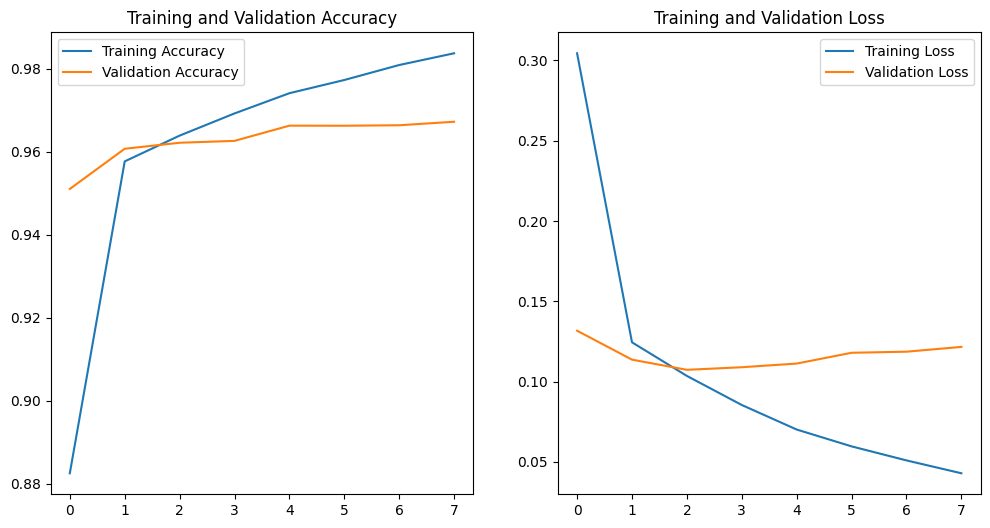

In [25]:
# Plotting training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training_history(history)


##  Generate the Confusion Matrix and Metrics

With the true labels and predictions, we can now generate a confusion matrix and calculate other evaluation metrics like precision, recall, and F1-score.

1595/1595 [==============================] - 135s 84ms/step


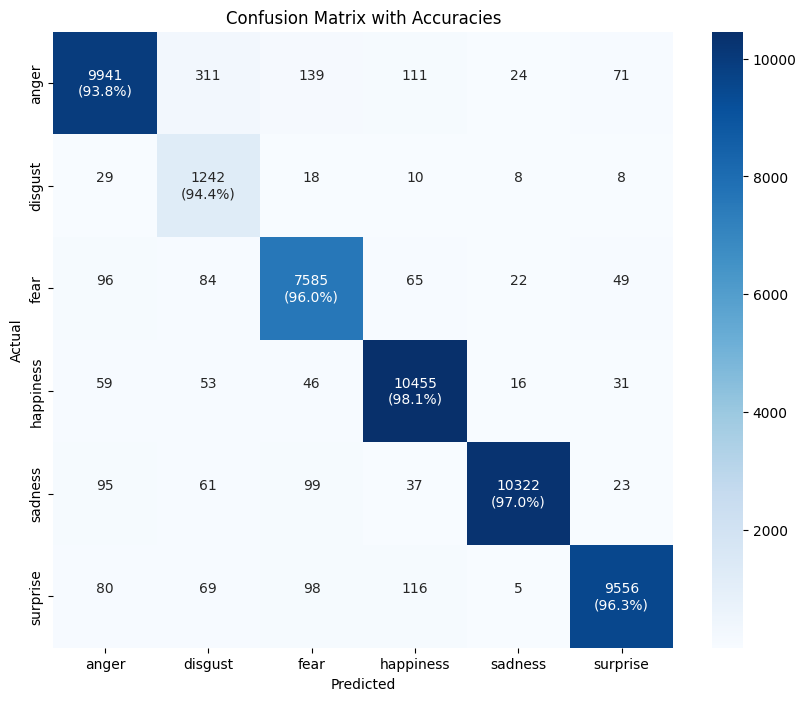

In [26]:
# Predict classes with the model
# Adjust the predict call to match your model inputs
predictions = model.predict({
    "text_input": val_input_ids, 
    "mask_input": val_attention_masks, 
    "numerical_input": numerical_features_val
})

# Assuming your model's final layer uses a softmax activation, predictions are probabilities
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(val_labels, predicted_labels)

# Calculate per-class accuracies
accuracies = cm.diagonal() / cm.sum(axis=1)

# Create an annotated confusion matrix with accuracies
cm_with_acc = cm.astype('str')  # Convert counts to string for annotation
for i in range(len(cm)):
    for j in range(len(cm[i])):
        # Append accuracy to the diagonal elements
        if i == j:
            cm_with_acc[i][j] = f"{cm[i][j]}\n({accuracies[i]*100:.1f}%)"
        else:
            cm_with_acc[i][j] += "\n "

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=cm_with_acc, fmt='', ax=ax, cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix with Accuracies')
plt.show()

## Prepare the Submission DataFrame and Save

In [27]:
# Function to encode sentences (tokenize)
def encode_sentences(df):
    encoded_dict = tokenizer.batch_encode_plus(
        df['sentence'].values,
        add_special_tokens=True,
        max_length=128,  # Adjust to your setup
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='np'
    )
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [28]:
# Load the test dataset
test_df = pd.read_csv('test (1).csv', sep='\t')

# Ensure 'sentence' column is string and apply the clean_text function
test_df['sentence'] = test_df['sentence'].astype(str).apply(clean_text)

# Add punctuation features to the test dataset
test_df['ends_with_exclamation'] = test_df['sentence'].str.endswith('!').astype(int)
test_df['ends_with_question'] = test_df['sentence'].str.endswith('?').astype(int)
test_df['ends_with_period'] = test_df['sentence'].str.endswith('.').astype(int)

# Prepare the numerical features for the test dataset
numerical_features_test = test_df[['ends_with_exclamation', 'ends_with_question', 'ends_with_period']].values
# Assuming 'scaler' is already fitted with your training data
numerical_features_test = scaler.transform(numerical_features_test)

# Tokenize the sentences in the test dataset
test_input_ids, test_attention_masks = encode_sentences(test_df)

# Prepare the TensorFlow dataset for the test data
test_dataset = tf.data.Dataset.from_tensor_slices(({
    "text_input": test_input_ids, 
    "mask_input": test_attention_masks, 
    "numerical_input": numerical_features_test
})).batch(BATCH_SIZE)

# Predictions
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Assuming label_encoder is fitted with your original labels
predicted_emotions = label_encoder.inverse_transform(predicted_labels)

# Prepare your submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],  # Make sure 'id' column exists in your test_df
    'emotion': predicted_emotions
})

# Save the submission file
submission_df.to_csv('Roberta_V3_5f_task12_submission.csv', index=False, sep=',')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


23/23 [==============================] - 5s 143ms/step


In [30]:
import joblib

# Define the base directory for saving
base_save_dir = "Roberta_V3_5f_task12_model"

# Ensure the base directory exists
if not os.path.exists(base_save_dir):
    os.makedirs(base_save_dir)

# Specify the paths for the model, tokenizer, and label encoder
model_save_path = os.path.join(base_save_dir, "model")
tokenizer_save_path = os.path.join(base_save_dir, "tokenizer")
label_encoder_save_path = os.path.join(base_save_dir, "label_encoder.joblib")

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

# Save the label encoder
joblib.dump(label_encoder, label_encoder_save_path)

['Roberta_V3_5f_task12_model/label_encoder.joblib']

In [ ]:
data_sub = 'Roberta_V3_5f_task12.csv'

# Load the dataset
data_submission = pd.read_csv(data_sub)

# Define the mapping from integer labels to emotion names
emotion_mapping = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise'
}

# Apply the mapping to the 'emotion' column
data_submission['emotion'] = data_submission['emotion'].map(emotion_mapping)
# Save the submission file
data_submission.to_csv('Roberta_V3_5f_task12.csv', index=False, sep=',')